In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [2]:
ACTIVITY_IDS = {
    0:"other (transient activities)",
    1 :"lying",
    2 :"sitting",
    3 :"standing",
    4 :"walking",
    5 :"running",
    6 :"cycling",
    7 :"Nordic walking",
    9 :"watching TV",
    10:"computer work",
    11:"car driving",
    12:"ascending stairs",
    13:"descending stairs",
    16:"vacuum cleaning",
    17:"ironing",
    18:"folding laundry",
    19:"house cleaning",
    20:"playing soccer",
    24:"rope jumping",
    }

LABEL_FOR_TRAINING = [4,5,12,13,24]

COLS_FOR_TRAINING = ['IMU Hand Acc X1', 'IMU Hand Acc Y1', 'IMU Hand Acc Z1',  'IMU Anckle Acc X1', 'IMU Anckle Acc Y1', 'IMU Anckle Acc Z1', "labels"]


In [3]:

def normalized_datasets(dataframe:pd.DataFrame, scaler:StandardScaler):
    labels_values = dataframe['labels'].values    
    
    normalized_values = scaler.transform(dataframe.values)

    _dset =  pd.DataFrame(data=normalized_values, columns=dataframe.columns, index=dataframe.index)
    _dset['labels'] = labels_values
    return _dset

def normalize_datasets(datasets:tuple):
    dsets = pd.concat(datasets)
    
    _dset_values = dsets.values
    
    scaler = StandardScaler()
    scaler.fit(_dset_values)
    
    normalized_dsets = [normalized_datasets(d, scaler) for d in datasets]
    
    return normalized_dsets

In [4]:
def generate_cols():
    imu_cols= []
    cols = ["t_stamp", "Activity ID", "Heart Rate"]
    
    for i in ['Hand', "Chest", "Anckle"]:
        c = [
            f"IMU {i} Temperature", 
            f"IMU {i} Acc X1", f"IMU {i} Acc Y1", f"IMU {i} Acc Z1", 
            f"IMU {i} Acc X2", f"IMU {i} Acc Y2", f"IMU {i} Acc Z2", 
            f"IMU {i} Gyr X", f"IMU {i} Gyr Y", f"IMU {i} Gyr Z", 
            f"IMU {i} Mag X", f"IMU {i} Mag Y", f"IMU {i} Mag Z",
            f"invalid", f"invalid", f"invalid", "invalid"]
        imu_cols.extend(c)
        
    cols.extend(imu_cols)
    return cols


def load_subject(filename:str): 
    df_s = pd.read_csv(filename, delimiter=" ")
    df_s.columns = generate_cols()
    
    df_s = df_s.drop(columns=["invalid"])
    df_s = df_s.set_index(["t_stamp"])
    df_s = df_s.ffill()
    df_s = df_s.rename(columns={"Activity ID":"labels"})
    
    # df_s["Heart Rate"] = df_s["Heart Rate"].ffill()
    
    return df_s

## Load Subject Data

In [5]:
SUBJECT_FOLDER = "data/PAMAP2"

df_s1 = load_subject(f"{SUBJECT_FOLDER}/subject101.dat")
df_s5 = load_subject(f"{SUBJECT_FOLDER}/subject105.dat")
df_s6 = load_subject(f"{SUBJECT_FOLDER}/subject106.dat")
df_s8 = load_subject(f"{SUBJECT_FOLDER}/subject108.dat")

(df_s1, df_s5, df_s6, df_s8) = normalize_datasets(((df_s1, df_s5, df_s6, df_s8)))

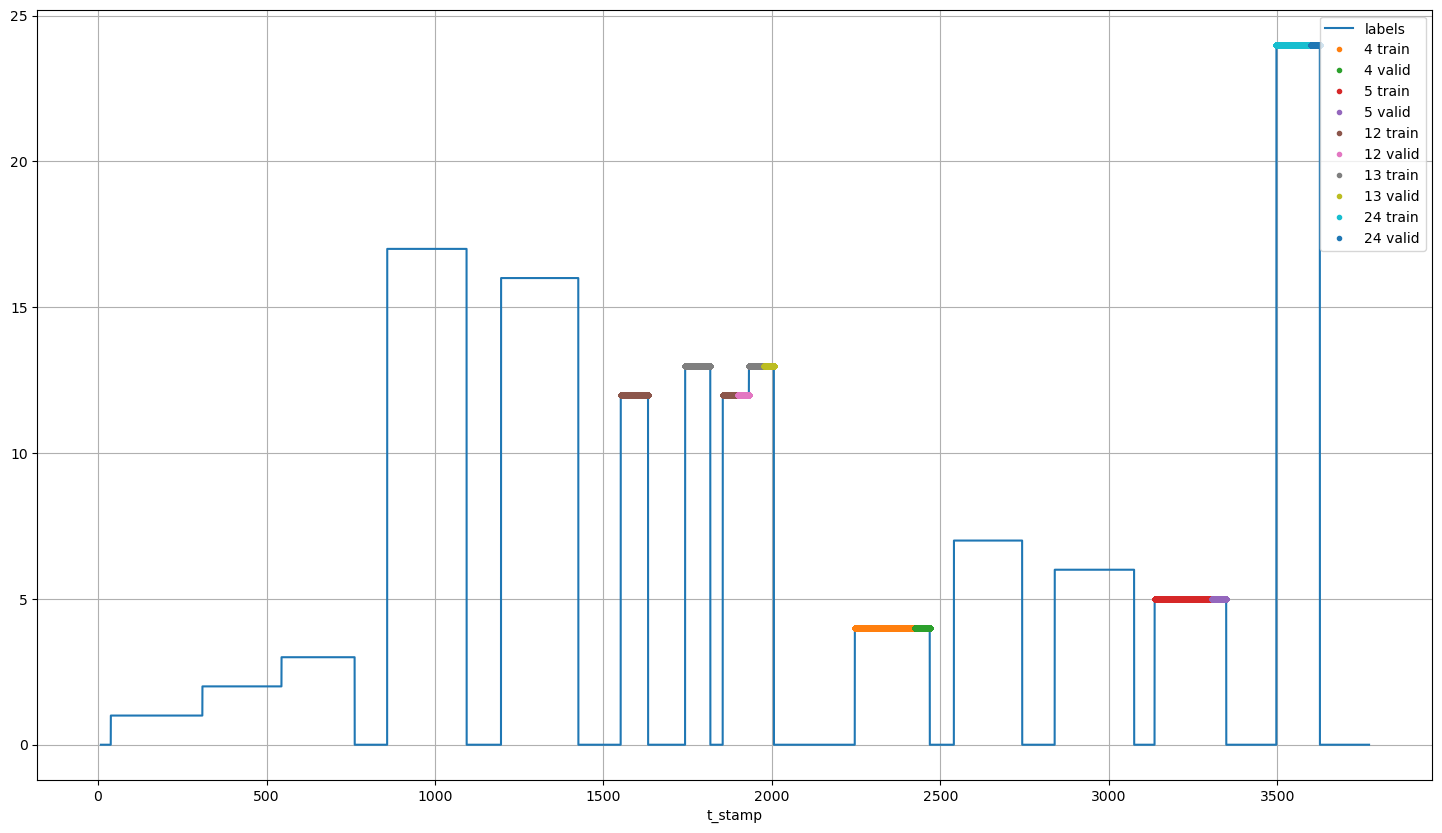

In [6]:
split = 0.8
plt.figure(figsize=(18, 10))
ax = plt.subplot(111)

df_s1["labels"].plot(ax=ax)


for l in LABEL_FOR_TRAINING:
    
    idxs = df_s1[df_s1["labels"] == l].index.values
    train_end_idx = int(idxs.shape[0]*split)
    
    train_idxs, test_idxs = idxs[:train_end_idx], idxs[train_end_idx:]
    
    df_s1.loc[train_idxs]["labels"].plot(style=".", ax=ax, label=f"{l} train")
    df_s1.loc[test_idxs]["labels"].plot(style=".", ax=ax, label=f"{l} valid")

ax.legend()
ax.grid()

# Make Train Test Dataset

In [11]:
def make_train_valid_split(dataset:pd.DataFrame, labels:list, train_split:float=0.8):
    train_datasets, valid_datasets = [], []
    
    for l in labels:
        
        idxs = dataset[dataset["labels"] == l].index.values
        train_end_idx = int(idxs.shape[0]*train_split)
        
        train_idxs, test_idxs = idxs[:train_end_idx], idxs[train_end_idx:]
        
        train_part = dataset.loc[train_idxs]
        valid_part = dataset.loc[test_idxs]
        
        train_datasets.append(train_part)
        valid_datasets.append(valid_part)
        
        print(f"[+] Content {ACTIVITY_IDS[l]}: Train Size: {train_part.shape}; Test Size: {valid_part.shape}")
        
    train_datasets = np.concatenate(train_datasets)
    valid_datasets = np.concatenate(valid_datasets)
    
    train_datasets = pd.DataFrame(data=train_datasets, columns=dataset.columns)
    valid_datasets = pd.DataFrame(data=valid_datasets, columns=dataset.columns)
    
    return train_datasets, valid_datasets

In [12]:
dfs1_train, dfs1_valid = make_train_valid_split(df_s1, LABEL_FOR_TRAINING)
dfs5_train, dfs5_valid = make_train_valid_split(df_s5, LABEL_FOR_TRAINING)
dfs6_train, dfs6_valid = make_train_valid_split(df_s6, LABEL_FOR_TRAINING)
dfs8_train, dfs8_valid = make_train_valid_split(df_s8, LABEL_FOR_TRAINING)

dfs1_train[COLS_FOR_TRAINING].to_hdf(f"{SUBJECT_FOLDER}/subject101_train.h5", key="data")
dfs1_valid[COLS_FOR_TRAINING].to_hdf(f"{SUBJECT_FOLDER}/subject101_valid.h5", key="data")

dfs5_train[COLS_FOR_TRAINING].to_hdf(f"{SUBJECT_FOLDER}/subject105_train.h5", key="data")
dfs5_valid[COLS_FOR_TRAINING].to_hdf(f"{SUBJECT_FOLDER}/subject105_valid.h5", key="data")

dfs6_train[COLS_FOR_TRAINING].to_hdf(f"{SUBJECT_FOLDER}/subject106_train.h5", key="data")
dfs6_valid[COLS_FOR_TRAINING].to_hdf(f"{SUBJECT_FOLDER}/subject106_valid.h5", key="data")

dfs8_train[COLS_FOR_TRAINING].to_hdf(f"{SUBJECT_FOLDER}/subject108_train.h5", key="data")
dfs8_valid[COLS_FOR_TRAINING].to_hdf(f"{SUBJECT_FOLDER}/subject108_valid.h5", key="data")

[+] Content walking: Train Size: (17802, 41); Test Size: (4451, 41)
[+] Content running: Train Size: (17012, 41); Test Size: (4253, 41)
[+] Content ascending stairs: Train Size: (12712, 41); Test Size: (3178, 41)
[+] Content descending stairs: Train Size: (11919, 41); Test Size: (2980, 41)
[+] Content rope jumping: Train Size: (10329, 41); Test Size: (2583, 41)
[+] Content walking: Train Size: (25626, 41); Test Size: (6407, 41)
[+] Content running: Train Size: (19716, 41); Test Size: (4930, 41)
[+] Content ascending stairs: Train Size: (11424, 41); Test Size: (2857, 41)
[+] Content descending stairs: Train Size: (10181, 41); Test Size: (2546, 41)
[+] Content rope jumping: Train Size: (6186, 41); Test Size: (1547, 41)
[+] Content walking: Train Size: (20576, 41); Test Size: (5145, 41)
[+] Content running: Train Size: (18260, 41); Test Size: (4565, 41)
[+] Content ascending stairs: Train Size: (10632, 41); Test Size: (2659, 41)
[+] Content descending stairs: Train Size: (9017, 41); Test 